<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#加载数据" data-toc-modified-id="加载数据-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>加载数据</a></span></li><li><span><a href="#精度-召回率-F" data-toc-modified-id="精度-召回率-F-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>精度-召回率-F</a></span></li><li><span><a href="#示例图" data-toc-modified-id="示例图-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>示例图</a></span></li><li><span><a href="#和灰度区分法对比" data-toc-modified-id="和灰度区分法对比-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>和灰度区分法对比</a></span></li></ul></div>

In [1]:
data_set = '03_brightness'
base_path = f'/home/liucc/Workspace/02_Ellipse/03_results/{data_set}/05_ellipse_result/'
raw_path = f'/home/liucc/Workspace/02_Ellipse/03_results/{data_set}/01_raw/'

In [2]:
import os 
dirs = os.listdir(base_path)
dirs = [d for d in dirs if d[0]!='.']
dirs.sort()
print(dirs)

['2012_param', '2014_fast', '2017_fast', '2018_high', 'proposed']


In [3]:
fnames = os.listdir(raw_path)
fnames = [n.split('.')[0] for n in fnames if n[-3:]=='png']
fnames.sort()
print(fnames)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040']


# 加载数据

In [4]:
import sys
import imageio

gts = []
raws = []

for name in fnames:
    
    rname = raw_path + name + '.png'
    
    im_raw = imageio.imread(rname)
    raws.append(im_raw)
    
print(len(raws))

40


# 精度-召回率-F

In [5]:
import re
import sys
sys.path.append('/home/liucc/Workspace/02_Ellipse/05_experiments')
from experiment import *

results = dict()

for dd in dirs:
    
    prs = []
    
    if len(os.listdir(base_path + dd))<len(fnames):
        continue
    
    for name in fnames:
        lname = base_path + dd + '/' + name + '.txt'

        with open(lname,'r') as f:
            txt = f.read()
            txt = txt.strip()
            
            txt = re.sub(r'[\f\r\t\v]+',' ',txt)
            if txt!='':
                ells_t = [[float(v) for v in l.split(' ')] for l in txt.split('\n') if len(l.split(' '))==5]
            
                prs.append(ells_t)
            else:
                prs.append([])
            
    results[dd] = prs
    print(f'Algorithm:{dd}')
    
    print('')

Algorithm:2012_param

Algorithm:2014_fast

Algorithm:2017_fast

Algorithm:2018_high

Algorithm:proposed



# 示例图

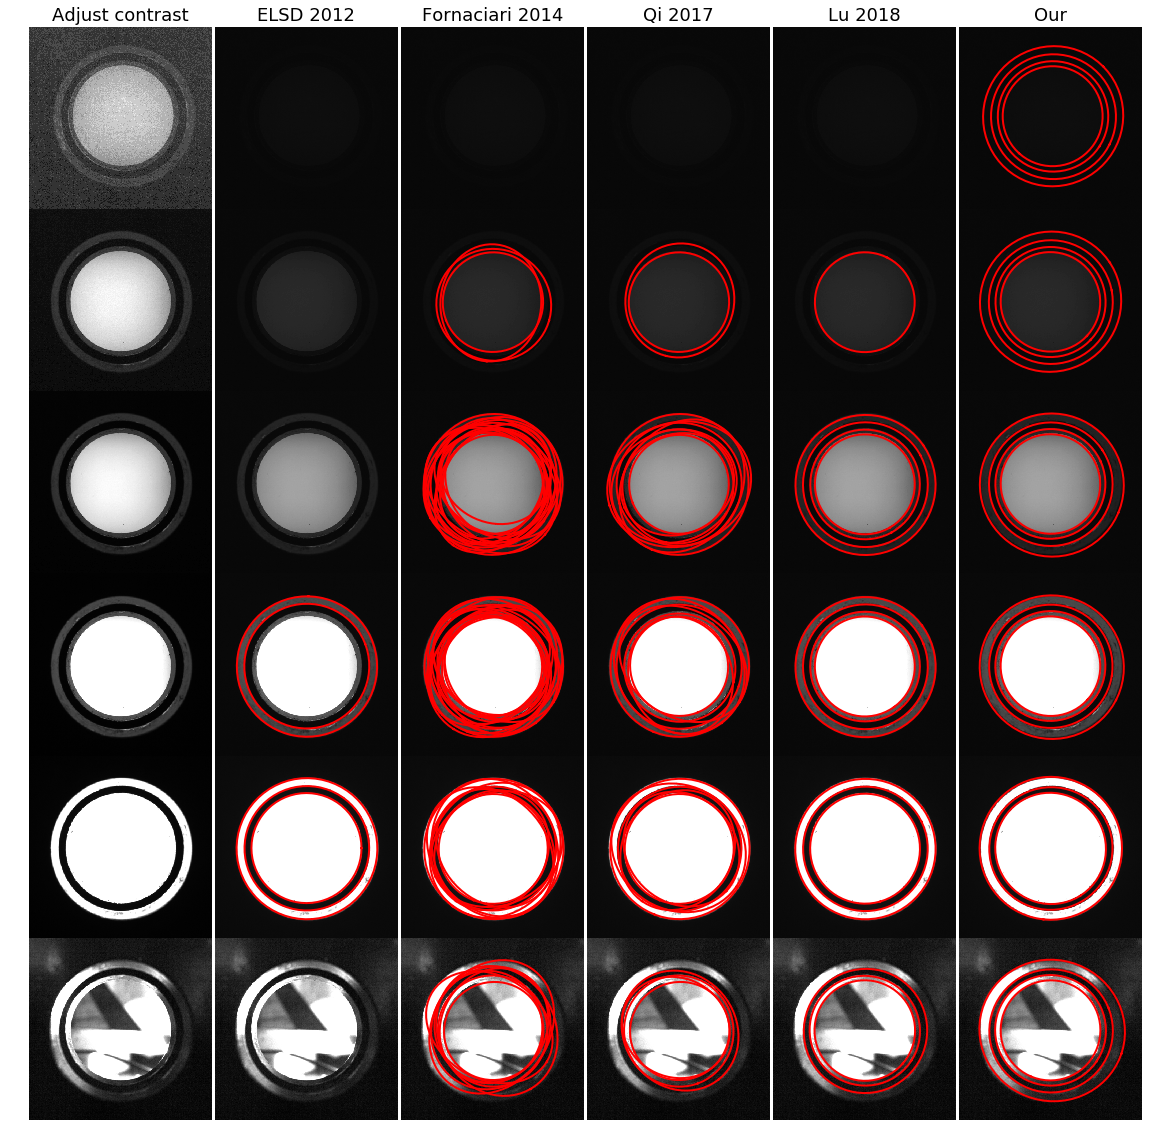

In [9]:
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.color import rgb2gray
from pylab import *

from matplotlib.font_manager import FontProperties
fp = FontProperties(family="DejaVu Sans",size=18)

title = {'2012_param':'ELSD 2012',
         '2012_very':'Fornaciari 2012',
         '2014_fast':'Fornaciari 2014',
         '2017_fast':'Qi 2017',
         '2018_high':'Lu 2018',
         'proposed':'Our',
         'original':'Original images',
         'adjust_contrast':'Adjust contrast'}


examples = [0,5,15,21,31,37]
num = len(examples)

hs = np.array([m.shape[0]/m.shape[1] for m in raws])
hs = hs[examples]

anum = len(results)+1

fig = plt.figure(figsize=(20,sum(hs)*20/anum+0.1))
gs = gridspec.GridSpec(num,anum,
                       wspace=0.0,
                       hspace=0.0,
                       width_ratios=[1]*anum,
                       height_ratios=hs,
                       )

for i,alg in enumerate(results):
    
    prs = results[alg]
                      
    for j in range(num):
        
        ax = fig.add_subplot(gs[j,i+1])
        _id = examples[j]
        raw,pr = raws[_id],prs[_id]
        draw_ellipse(pr,ax,'red',1,wire=True)
        gray = rgb2gray(raw)
        ax.imshow(gray,cmap='gray',alpha=1,vmin=0,vmax=255)
        
        if j==0:
            ax.set_title(title[alg],fontproperties=fp)
            
        ax.axis('off')
    
for j in range(num):
    ax = fig.add_subplot(gs[j,0])
    
    _id = examples[j]
    if j==0:
        ax.set_title(title['adjust_contrast'],fontproperties=fp)
        
    ax.imshow(raws[_id],cmap='gray')
    ax.axis('off')
    
'''for j in range(num):
    ax = fig.add_subplot(gs[j,1])
    
    _id = examples[j]
    gray = rgb2gray(raws[_id])
    draw_ellipse(gts[_id],ax,'red',1,wire=True)
    if j==0:
        ax.set_title(title['GT'],fontproperties=fp)
        
    ax.imshow(gray,cmap='gray',alpha=0.5)
    ax.axis('off')'''
    


plt.show()

pp = PdfPages('../images/comparison_brightness.pdf')
pp.savefig(fig,bbox_inches ='tight')
pp.close()

# 和灰度区分法对比

In [11]:
from shapely.geometry.point import Point
from shapely import affinity
from matplotlib.patches import Polygon
from shapely.ops import unary_union

def get_gap(im,ells):
    ells = sorted(ells,key=lambda x:x[2])

    h,w = im.shape
    xs,ys = np.meshgrid(np.arange(w),np.arange(h))
    xs = xs.flatten()
    ys = ys.flatten()
    vs = im.flatten()

    data = np.zeros((len(xs),len(ells)),dtype=np.int)

    for i,ell in enumerate(ells):
        x,y,a,b,theta = ell

        xs_ = xs-x
        ys_ = ys-y

        ev = np.stack((xs_,ys_),axis=0)

        alpha = -theta*np.pi/180

        R_rot = np.array([[np.cos(alpha) , -np.sin(alpha)],[np.sin(alpha) , np.cos(alpha)]])  

        ev = np.dot(R_rot,ev) #反向补偿

        assert b>0

        ev[1,:] = ev[1,:]*a/b

        dis = np.sqrt(np.sum(ev**2,axis=0))-a

        data[:,i] = np.sign(dis)

    gray_min = 100000
    res_sel = None
    for i in range(1,len(ells),1):

        id_sel = np.where((data[:,i]<0) & (data[:,i-1]>0))[0]

        v_sel = vs[id_sel]
        gray_avg = np.mean(v_sel)

        if gray_avg<gray_min:
            res_sel = id_sel
            gray_min = gray_avg


    imo = np.zeros_like(vs,dtype=np.bool)

    if res_sel is not None:
        imo[res_sel] = True

    imo = imo.reshape((h,w))
    
    return imo

In [12]:


import time
t1 = time.time()
imo = get_gap(raws[0],results['proposed'][0])
t2 = time.time()

print(t2-t1)

0.033283233642578125


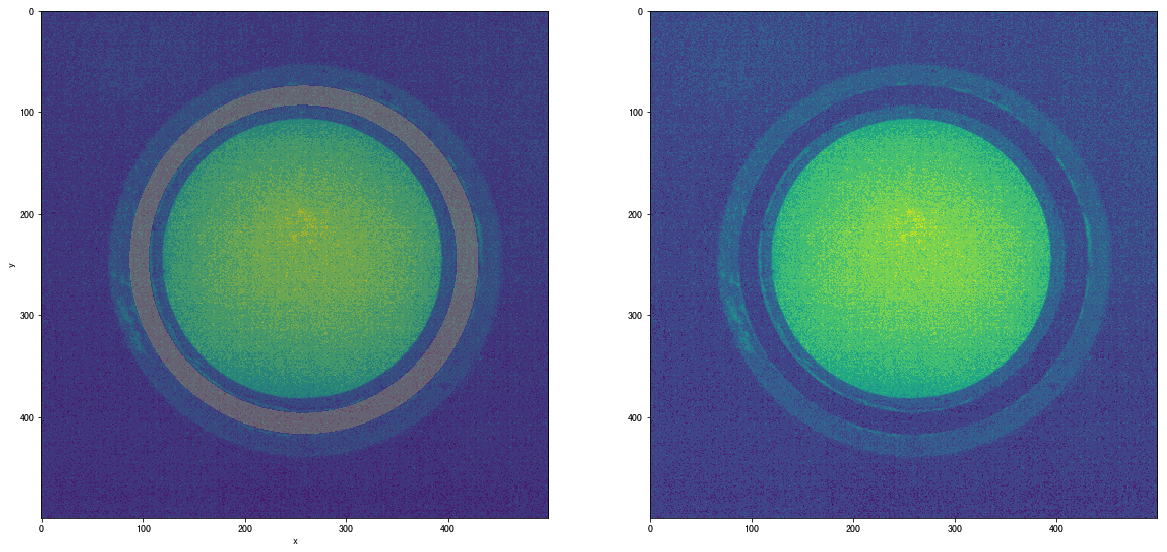

In [13]:
_,axes = plt.subplots(ncols=2,figsize=(20,10))
axes[0].imshow(raws[0])
axes[0].imshow(imo,alpha=0.2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

axes[1].imshow(raws[0])

plt.show()

In [14]:
egs = []
for im,ell in zip(raws,results['proposed']):
    egs.append(get_gap(im,ell))
    
print(len(egs))

40


In [15]:
thresh_path = f'/home/liucc/Workspace/02_Ellipse/03_results/{data_set}/06_thresh/'

thrs = []
for name in fnames:
    
    rname = thresh_path + name + '.png'
    
    im_thr = imageio.imread(rname)
    thrs.append(im_thr)
    
print(len(thrs))

40


In [16]:
def combine_ims(imb,imt):
    
    if np.max(imb)<=1:
        imb = imb*255
        imb = imb.tobytes()
        
    imo = np.stack((imb,imb,imb),axis=2)
    imo[:,:,0] = np.where(imt,240,imb)
    
    return imo

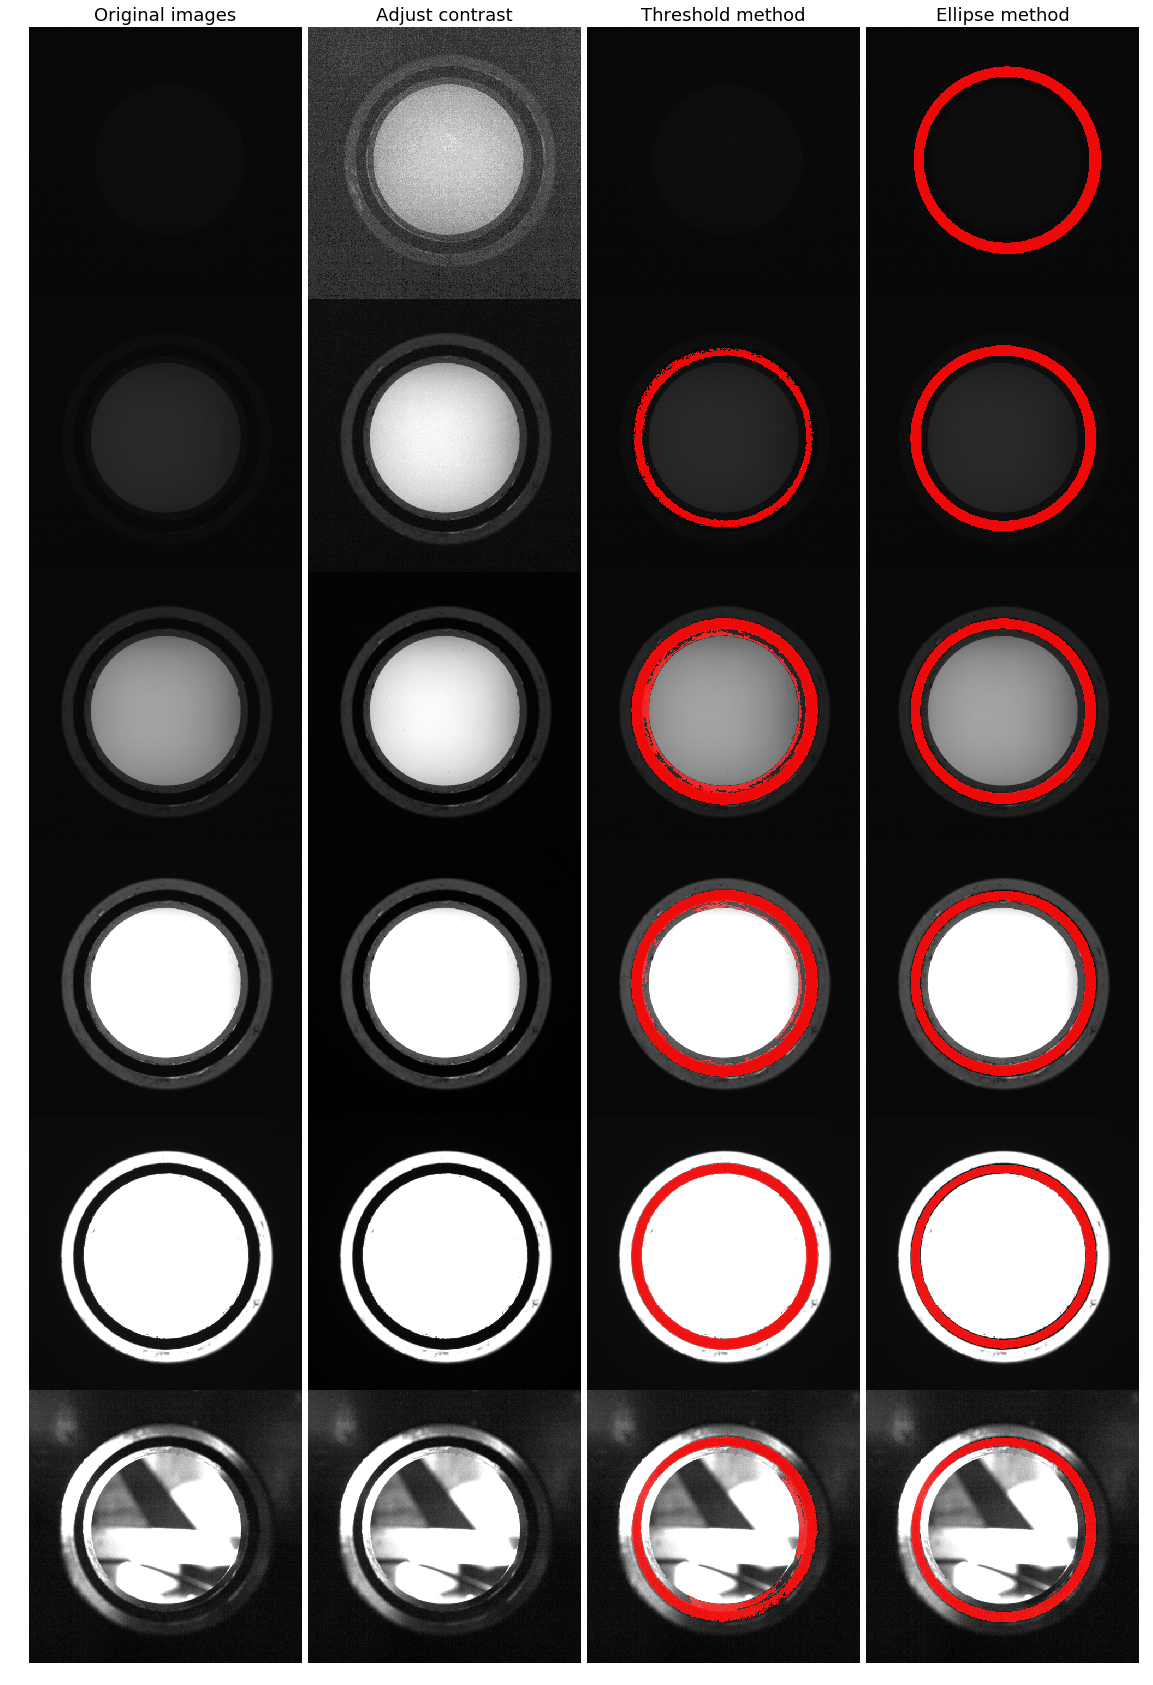

In [17]:
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.color import rgb2gray
from pylab import *

from matplotlib.font_manager import FontProperties
fp = FontProperties(family="DejaVu Sans",size=18)

title = {'2012_param':'ELSD 2012',
         '2012_very':'Fornaciari 2012',
         '2014_fast':'Fornaciari 2014',
         '2017_fast':'Qi 2017',
         '2018_high':'Lu 2018',
         'proposed':'Our',
         'original':'Original images'}


#examples = [0,5,9,15,21,27,31,35,37,39]
examples = [0,5,15,21,31,37]
num = len(examples)

hs = np.array([m.shape[0]/m.shape[1] for m in raws])
hs = hs[examples]

anum = 2+2

fig = plt.figure(figsize=(20,sum(hs)*20/anum+0.1))
gs = gridspec.GridSpec(num,anum,
                       wspace=0.0,
                       hspace=0.0,
                       width_ratios=[1]*anum,
                       height_ratios=hs,
                       )



#阈值法求中环
for j in range(num):
    ax = fig.add_subplot(gs[j,2])
    _id = examples[j]
    raw,th = raws[_id],thrs[_id]
    
    imo = combine_ims(raw,th)
    ax.imshow(imo)

    if j==0:
        ax.set_title('Threshold method',fontproperties=fp)

    ax.axis('off')
    
#椭圆法求中环
for j in range(num):

    ax = fig.add_subplot(gs[j,3])
    _id = examples[j]
    raw,eg = raws[_id],egs[_id]
    imo = combine_ims(raw,eg)
    ax.imshow(imo)

    if j==0:
        ax.set_title('Ellipse method',fontproperties=fp)

    ax.axis('off')

    
for j in range(num):
    ax0 = fig.add_subplot(gs[j,0])
    ax1 = fig.add_subplot(gs[j,1])
    
    _id = examples[j]
    if j==0:
        ax0.set_title(title['original'],fontproperties=fp)
        ax1.set_title('Adjust contrast',fontproperties=fp)
        
    ax0.imshow(raws[_id],cmap='gray',vmin=0,vmax=255)
    ax0.axis('off')
    
    ax1.imshow(raws[_id],cmap='gray')
    ax1.axis('off')

    


plt.show()

pp = PdfPages('../images/comparison_brightness_ring.pdf')
pp.savefig(fig,bbox_inches ='tight')
pp.close()